In [35]:
# Importing useful libraries
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import string

# Adding NLTK path to fix VADER
nltk.data.path.append("C:/Users/Dhwani/AppData/Roaming/nltk_data")
sia = SentimentIntensityAnalyzer()

# Loading Reddit (your combined 6-subbed file)
reddit = pd.read_csv("reddit_6_subreddits_combined.csv")

# Loading Twitter (Airline sentiment dataset)
twitter = pd.read_csv("Tweets.csv")

print("Reddit shape:", reddit.shape)
print("Twitter shape:", twitter.shape)

Reddit shape: (5931, 19)
Twitter shape: (14640, 15)


In [36]:
# Cleaning Reddit datasets

reddit_small = reddit[["title", "subreddit"]].copy()
reddit_small["source"] = "reddit"
reddit_small = reddit_small.rename(columns={"title": "text"})

In [37]:
# Cleaning Twitter dataset

twitter_small = twitter[["text", "airline", "airline_sentiment"]].copy()
twitter_small["source"] = "twitter"

In [38]:
# Merging the Reddit and Twitter datasets into one

combined = pd.concat([reddit_small, twitter_small], ignore_index=True)
combined.head()

,text,subreddit,source,airline,airline_sentiment
0,"People who haven't pooped in 2019 yet, why are...",AskReddit,reddit,NaN,NaN
1,How would you feel about Reddit adding 3 NSFW ...,AskReddit,reddit,NaN,NaN
2,Would you watch a show where a billionaire CEO...,AskReddit,reddit,NaN,NaN
3,"What if God came down one day and said ""It's p...",AskReddit,reddit,NaN,NaN
4,How would you feel about a feature where if so...,AskReddit,reddit,NaN,NaN


In [39]:
# Final dataset converting to csv file for data visualisation on RapidMiner

combined.to_csv("combined_cleaned_dataset.csv", index=False)
print("Total posts:", len(combined))

Total posts: 20571


In [40]:
# Part-2 Importing remaining libraries
import matplotlib.pyplot as plt

# NLP & modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

In [41]:
# Checking our previous dataset

df = pd.read_csv("combined_cleaned_dataset.csv")
print("rows:", len(df))
print(df.columns.tolist())
df.sample(5)[['text','source']].fillna('').head()

rows: 20571
['text', 'subreddit', 'source', 'airline', 'airline_sentiment']


,text,source
2942,Tesla’s Touchscreen Shifter Seems Like a Reall...,reddit
18590,@AmericanAir We tried with multiple people. I ...,twitter
1255,"TIL In 1988, Israel Kamakawiwoʻole called a st...",reddit
18836,@AmericanAir stuck at gate Miami to JFK flight...,twitter
2455,'Tis The Season: Congress Looks To Sneak In Un...,reddit


In [42]:
# A simple text-based proxy
# We are using sentiment magnitude + text length as a basic signal.
df['text'] = df['text'].astype(str)
df['vader_compound'] = df['text'].apply(lambda t: sia.polarity_scores(t)['compound'])
df['sent_mag'] = df['vader_compound'].abs()
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Normalising word_count
df['word_count_norm'] = df['word_count'] / df['word_count'].max()

# Engagement proxy: combination (tunable)
df['engagement_proxy'] = df['sent_mag'] * 2.0 + df['word_count_norm'] * 1.0

# Creating is_viral: top 5% by engagement_proxy (or real metric)
threshold = df['engagement_proxy'].quantile(0.95)
df['is_viral'] = (df['engagement_proxy'] >= threshold).astype(int)

print("Viral ratio:", df['is_viral'].mean())

Viral ratio: 0.05002187545573866


In [43]:
# Basic text statistics
df['char_len'] = df['text'].str.len()
df['hashtag_count'] = df['text'].str.count('#')
df['mention_count'] = df['text'].str.count('@')
df['exclaim_count'] = df['text'].str.count('!')

# Creating a simple 'contains_question' feature
df['contains_question'] = df['text'].str.contains(r'\?').astype(int)

# Filling NA if any
df.fillna({'vader_compound':0, 'word_count':0}, inplace=True)

In [44]:
# Summarising statistics for engineered features

df[['char_len',
    'word_count',
    'hashtag_count',
    'mention_count',
    'exclaim_count',
    'vader_compound']].describe()

,char_len,word_count,hashtag_count,mention_count,exclaim_count,vader_compound
count,20571.000000,20571.000000,20571.000000,20571.000000,20571.000000,20571.000000
mean,103.271450,17.666715,0.177872,0.806281,0.265762,0.026053
std,53.149257,9.573747,0.571319,0.618898,0.797178,0.448145
min,3.000000,1.000000,0.000000,0.000000,0.000000,-0.977700
25%,65.000000,11.000000,0.000000,0.000000,0.000000,-0.296000
50%,105.000000,18.000000,0.000000,1.000000,0.000000,0.000000
75%,136.000000,23.000000,0.000000,1.000000,0.000000,0.401900
max,300.000000,63.000000,8.000000,6.000000,27.000000,0.976000


In [45]:
# Comparing averages between viral and non-viral posts

df.groupby('is_viral')[[
    'char_len',
    'word_count',
    'hashtag_count',
    'mention_count',
    'exclaim_count',
    'vader_compound'
]].mean()

,char_len,word_count,hashtag_count,mention_count,exclaim_count,vader_compound
is_viral,,,,,,
0,99.498670,16.987923,0.179971,0.812353,0.246137,0.022301
1,174.921283,30.557823,0.137998,0.690962,0.638484,0.097302


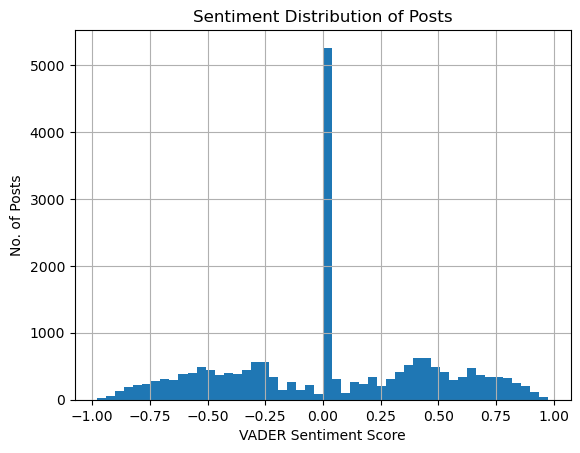

In [46]:
#Plot-1 -> Sentiment of posts, Negative to Positive

plt.figure()
df['vader_compound'].hist(bins=50)
plt.xlabel("VADER Sentiment Score")
plt.ylabel("No. of Posts")
plt.title("Sentiment Distribution of Posts")
plt.show()

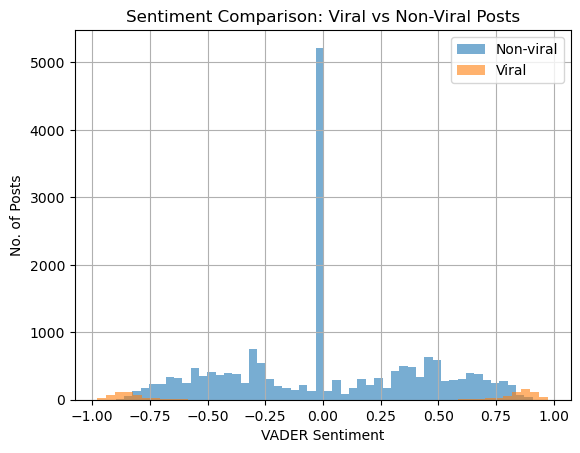

In [47]:
#Plot-2 -> Viral posts

plt.figure()
df[df['is_viral']==0]['vader_compound'].hist(bins=50, alpha=0.6, label='Non-viral')
df[df['is_viral']==1]['vader_compound'].hist(bins=50, alpha=0.6, label='Viral')
plt.legend()
plt.xlabel("VADER Sentiment")
plt.ylabel("No. of Posts")
plt.title("Sentiment Comparison: Viral vs Non-Viral Posts")
plt.show()

In [48]:
# Printing basic details of our dataset

print("Total posts:", len(df))
print("Viral posts:", df['is_viral'].sum())
print("Non-viral posts:", (df['is_viral']==0).sum())

Total posts: 20571
Viral posts: 1029
Non-viral posts: 19542


In [49]:
# Limiting vocab to keep model simpler and SHAP readable
tf = TfidfVectorizer(max_features=4000, ngram_range=(1,2), stop_words='english')
X_tfidf = tf.fit_transform(df['text'])

# Meta features (dense)
meta_cols = ['vader_compound','word_count','char_len','hashtag_count','mention_count','exclaim_count','contains_question']
X_meta = df[meta_cols].values

# Combining sparse + dense
from scipy.sparse import hstack
X = hstack([X_tfidf, X_meta])
y = df['is_viral'].values

print("Feature matrix shape:", X.shape)

Feature matrix shape: (20571, 4007)


In [50]:
# Splitting train and test data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42, stratify=y)

print("Train positives:", y_train.sum(), "Test positives:", y_test.sum())

Train positives: 823 Test positives: 206


In [51]:
# Logistic Regression model with class_weight
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0, solver='saga')
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
print("PR-AUC:", auc(recall, precision))

              precision    recall  f1-score   support

           0     0.9853    0.6679    0.7962      3909
           1     0.1140    0.8107    0.1999       206

    accuracy                         0.6751      4115
   macro avg     0.5496    0.7393    0.4980      4115
weighted avg     0.9417    0.6751    0.7663      4115

ROC-AUC: 0.8411929652010421
PR-AUC: 0.2847782307544523


C:\Users\Dhwani\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


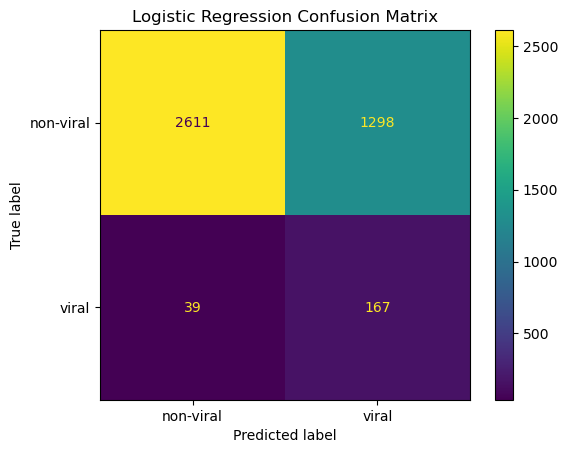

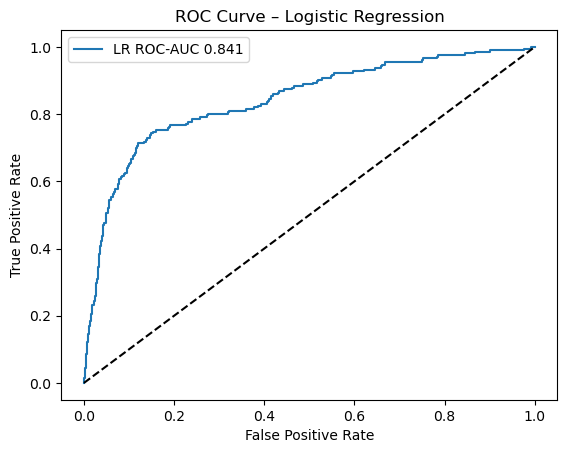

In [52]:
# Confusion matrix for Logistic Regression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    lr, X_test, y_test,
    display_labels=['non-viral','viral']
)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


# Getting probabilities for the positive (viral) class
y_prob = lr.predict_proba(X_test)[:, 1]

# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'LR ROC-AUC {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression')
plt.legend()
plt.show()

In [53]:
# Random Forest model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [54]:
# predictions
y_pred_rf = rf.predict(X_test)

# probabilities (needed for ROC)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [55]:
# Results of the Random Forest model

from sklearn.metrics import classification_report

print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf, target_names=['Non-viral', 'Viral']))

Random Forest Classification Report
              precision    recall  f1-score   support

   Non-viral       0.97      1.00      0.99      3909
       Viral       0.99      0.47      0.64       206

    accuracy                           0.97      4115
   macro avg       0.98      0.74      0.81      4115
weighted avg       0.97      0.97      0.97      4115



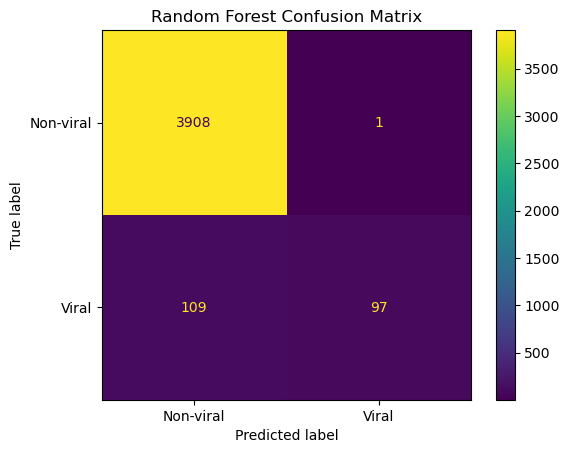

In [56]:
# Confusion matrix for the Random Forest Model

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    rf,
    X_test,
    y_test,
    display_labels=['Non-viral', 'Viral']
)
plt.title("Random Forest Confusion Matrix")
plt.show()

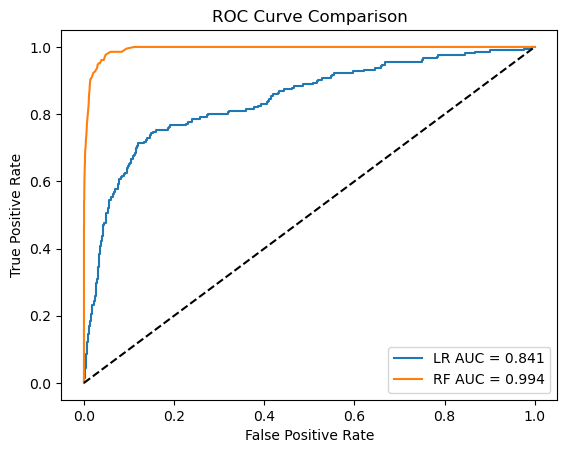

In [57]:
# ROC curve for the Random Forest model Vs Logistic Regression
from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'LR AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC = {roc_auc_score(y_test, y_proba_rf):.3f}')
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [58]:
# Getting the most importatnt features which affects the virality of the posts
importances = rf.feature_importances_

# Map importance to feature names
feature_names = tf.get_feature_names_out().tolist() + meta_cols
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feat_imp.head(15)

,feature,importance
4000,vader_compound,0.189155
4001,word_count,0.095022
4002,char_len,0.091720
3480,til,0.023987
4005,exclaim_count,0.015336
4006,contains_question,0.008073
247,americanair,0.007926
1602,great,0.007917
2152,love,0.007736
4004,mention_count,0.007412


<Figure size 800x500 with 0 Axes>

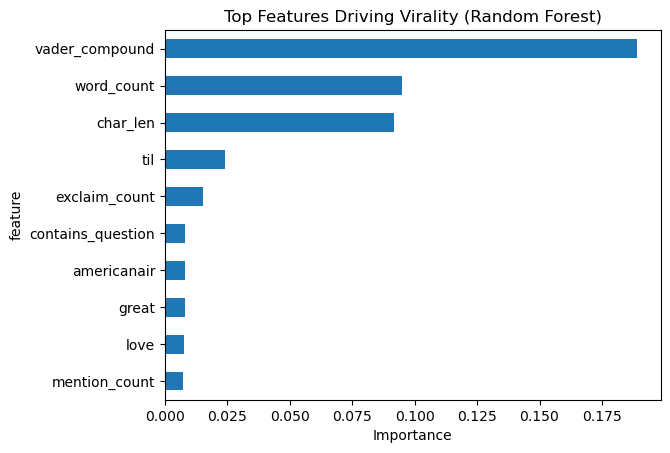

In [59]:
# Plotting a bar graph to see the important features and their importance in determining the virality of the posts

plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='barh', x='feature', y='importance', legend=False)
plt.title("Top Features Driving Virality (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

In [60]:
# Determining the viral posts by platform

df.groupby('source')['is_viral'].mean()

source
reddit     0.070983
twitter    0.041530
Name: is_viral, dtype: float64

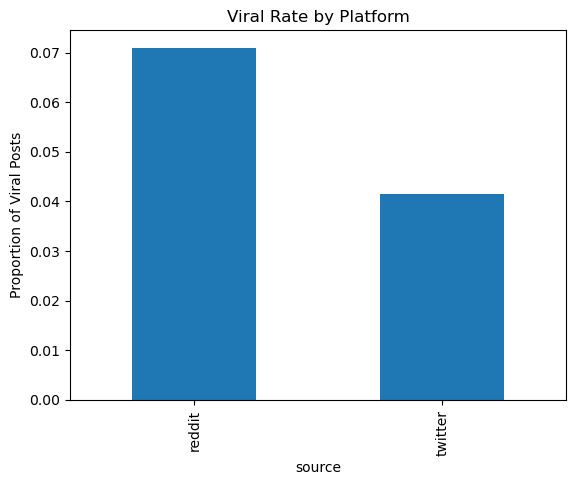

In [61]:
# Plotting the above result in the form of bar graph

df.groupby('source')['is_viral'].mean().plot(kind='bar')
plt.title("Viral Rate by Platform")
plt.ylabel("Proportion of Viral Posts")
plt.show()

In [62]:
# Saving the Random Forest Virality model and the text feature extraction model

import joblib

joblib.dump(rf, "viral_prediction_model.pkl")
joblib.dump(tf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [63]:
# Creating the predicting function

def predict_virality(text):
    text_vec = tf.transform([text])
    meta = np.array([[
        sia.polarity_scores(text)['compound'],
        len(text.split()),
        len(text),
        text.count('#'),
        text.count('@'),
        text.count('!'),
        int('?' in text)
    ]])
    from scipy.sparse import hstack
    X_new = hstack([text_vec, meta])
    return rf.predict(X_new)[0]

In [64]:
#Deploying model to test a random short negative sentiment input

predict_virality("This airline experience was absolutely horrible!!!")

np.int64(0)

In [65]:
# Deploying the model to test a random long detailed negative sentiment input

predict_virality(
    "This is the WORST airline experience I have EVER had in my entire life!!! \
    Absolutely disgusting service, endless delays, zero communication, \
    and complete disregard for passengers. \
    I will NEVER fly with this airline again!!! \
    Can everyone please share this so people know how terrible this is?"
)

np.int64(1)